# Save extended QC for bwm dataset

In [146]:
prefix = '/home/ines/repositories/'
prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [ ]:
"""
Check sessions available with dlc data
@author: Ines
"""
import pandas as pd
import pickle 
import os
import numpy as np
from one.api import ONE
import matplotlib.pyplot as plt
from brainbox.io.one import SessionLoader
from dateutil import parser

# Get my functions
functions_path =  prefix + '/representation_learning_variability/Functions/'

os.chdir(functions_path)
from video_functions import get_lick_times, lick_psth
from data_processing import save_and_log

one = ONE(mode='remote')


In [192]:
base_query = (
    'session__projects__name__icontains,ibl_neuropixel_brainwide_01,'
    '~session__json__IS_MOCK,True,'
    'session__qc__lt,50,'
    'session__extended_qc__behavior,1,'
    '~json__qc,CRITICAL,'  # Should clarify these
    'json__extended_qc__alignment_count__gt,0,'  # No need for alignment resolved
)
qc_task = (
    '~session__extended_qc___task_stimOn_goCue_delays__lt,0.9,'
    '~session__extended_qc___task_response_feedback_delays__lt,0.9,'
    '~session__extended_qc___task_wheel_move_before_feedback__lt,0.9,'
    '~session__extended_qc___task_wheel_freeze_during_quiescence__lt,0.9,'
    '~session__extended_qc___task_error_trial_event_sequence__lt,0.9,'
    '~session__extended_qc___task_correct_trial_event_sequence__lt,0.9,'
    '~session__extended_qc___task_reward_volumes__lt,0.9,'
    '~session__extended_qc___task_reward_volume_set__lt,0.9,'
    '~session__extended_qc___task_stimulus_move_before_goCue__lt,0.9,'
    '~session__extended_qc___task_audio_pre_trial__lt,0.9')

marked_pass = (
    'session__extended_qc___experimenter_task,PASS')  # What is this?

insertions = list(one.alyx.rest('insertions', 'list', django=base_query + qc_task))
insertions.extend(list(one.alyx.rest('insertions', 'list', django=base_query + marked_pass)))
print(len(insertions))

bwm_df = pd.DataFrame({
    'pid': np.array([i['id'] for i in insertions]),
    'eid': np.array([i['session'] for i in insertions]),
    'probe_name': np.array([i['name'] for i in insertions]),
    'session_number': np.array([i['session_info']['number'] for i in insertions]),
    'date': np.array([parser.parse(i['session_info']['start_time']).date() for i in insertions]),
    'subject': np.array([i['session_info']['subject'] for i in insertions]),
    'lab': np.array([i['session_info']['lab'] for i in insertions]),
}).sort_values(by=['lab', 'subject', 'date', 'eid'])
bwm_df.drop_duplicates(inplace=True)
bwm_df.reset_index(inplace=True, drop=True)

735


In [196]:
def extended_qc(one, bwm_df):
    
    eids = bwm_df['eid'].unique()

    # Initialize df
    df = pd.DataFrame()

    for e, eid in enumerate(eids):
        
        extended_qc = one.get_details(eid, True)['extended_qc']
        transposed_df = pd.DataFrame.from_dict(extended_qc, orient='index').T
        transposed_df['eid'] = eid
        df = pd.concat([df, transposed_df])
    
    return df

In [197]:
ext_qc = extended_qc(one, bwm_df)

In [199]:
ext_qc_path = prefix + '/representation_learning_variability/Video and wheel/Video QC/'
ext_qc.to_pickle(ext_qc_path+'extended_qc07-10-2025')  

In [208]:
ext_qc_path = prefix + '/representation_learning_variability/Video and wheel/Video QC/'
os.chdir(ext_qc_path)
ext_qc = pickle.load(open(ext_qc_path + "extended_qc07-10-2025", "rb"))
use_qc = ext_qc.loc[ext_qc['task'].isin(['PASS', 'WARNING'])]
use_qc = ext_qc
len(use_qc)

473

In [209]:
final_qc = use_qc.loc[(use_qc['_lightningPoseLeft_lick_detection'].isin(['PASS'])) &
                             (use_qc['_lightningPoseLeft_time_trace_length_match'].isin(['PASS'])) &   
                             (use_qc['_videoLeft_pin_state'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS')) &
                             (use_qc['_lightningPoseLeft_trace_all_nan'].isin(['PASS'])) &
                             (use_qc['_videoLeft_framerate'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS')) &   
                             (use_qc['_videoLeft_camera_times'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS')) &   
                             (use_qc['_videoLeft_dropped_frames'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS')) &  # can make more conservative by removing or  x == None
                             (use_qc['_videoLeft_timestamps'].isin([True, 'PASS']))                   
                            ]

print(len(final_qc))

218


In [210]:
final_qc.to_pickle(ext_qc_path+'final_lp_qc07-10-2025')  

### Get QC of all sessions

In [4]:
data_path =  prefix + '/representation_learning_variability/DATA/Brainwidemap/'

os.chdir(data_path)
qc = pd.read_csv("Brainwidemap_QC - behavior_data.csv")  # TODO: there should be a better way of doing this!  but good for now?


In [5]:
def extended_qc(one, qc):
    
    eids = qc['Session ID']

    # Initialize df
    df = pd.DataFrame()

    for e, eid in enumerate(eids):
        
        extended_qc = one.get_details(eid, True)['extended_qc']
        transposed_df = pd.DataFrame.from_dict(extended_qc, orient='index').T
        transposed_df['eid'] = eid
        df = pd.concat([df, transposed_df])
    
    return df

In [6]:
ext_qc = extended_qc(one, qc)

In [24]:
file_to_save = ext_qc.copy()
filename = "extended_qc"
save_path = prefix + '/representation_learning_variability/Video and wheel/Video QC/'
file_format = 'pickle'
script_name = 'extended_qc_lp.ipynb'
metadata = save_and_log(file_to_save, filename, file_format, save_path, script_name)

FileNotFoundError: [Errno 2] No such file or directory: '/home/ines/repositories/representation_learning_variability/DATA/metadata_log.json'

# Lightning pose QC

In [7]:
ext_qc_path = prefix + '/representation_learning_variability/Video and wheel/Video QC/'
os.chdir(ext_qc_path)
ext_qc = pickle.load(open(ext_qc_path + "extended_qc07-08-2025", "rb"))
use_qc = ext_qc.loc[ext_qc['task'].isin(['PASS', 'WARNING'])]


In [8]:
final_qc = use_qc.loc[(use_qc['_lightningPoseLeft_lick_detection'].isin(['PASS'])) &
                             (use_qc['_lightningPoseLeft_time_trace_length_match'].isin(['PASS'])) &   
                             (use_qc['_videoLeft_pin_state'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS')) &
                             (use_qc['_lightningPoseLeft_trace_all_nan'].isin(['PASS'])) &
                             (use_qc['_videoLeft_framerate'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS')) &   
                             (use_qc['_videoLeft_camera_times'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS')) &   
                             (use_qc['_videoLeft_dropped_frames'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS' or  x == None)) &  # can make more conservative by removing or  x == None
                             (use_qc['_videoLeft_timestamps'].isin([True, 'PASS']))                   
                            ]

print(len(final_qc))

254


In [208]:
file_to_save = final_qc.copy()
filename = "final_lp_qc07-09-2025"
save_path = prefix + '/representation_learning_variability/Video and wheel/Video QC/'
file_format = 'pickle'
metadata = save_and_log(file_to_save, filename, file_format, save_path)

TypeError: save_and_log() missing 1 required positional argument: 'script_name'

In [ ]:
final_qc.to_pickle(save_path+filename)  

In [136]:
def get_XYs(one, eid, view, likelihood_thresh=0.9, lp=True):
    try:
        times = one.load_dataset(eid, '_ibl_%sCamera.times.npy' % view)
        if lp:
            cam = one.load_dataset(eid, '_ibl_%sCamera.lightningPose.pqt' % view)
        else:
            cam = one.load_dataset(eid, '_ibl_%sCamera.dlc.pqt' % view)
    except KeyError:
        print('not all data available')
        return None, None

    if lp:
        keys = cam.keys()
        sufixes = np.array(['_'.join(x.split('_')[-1:]) for x in keys])
        Xs = keys[np.where(sufixes == 'x')]
        points = np.array(['_'.join(x.split('_')[:-1]) for x in Xs])
    else:
        points = np.unique(['_'.join(x.split('_')[:-1]) for x in cam.keys()])

    # Set values to nan if likelyhood is too low # for pqt: .to_numpy()
    XYs = {}
    for point in points:
        x = np.ma.masked_where(cam[point + '_likelihood'] < likelihood_thresh, cam[point + '_x'])
        x = x.filled(np.nan)
        y = np.ma.masked_where(cam[point + '_likelihood'] < likelihood_thresh, cam[point + '_y'])
        y = y.filled(np.nan)
        XYs[point] = np.array([x, y]).T
    return times, XYs


""" LICKs """

def get_licks(XYs):

    '''
    define a frame as a lick frame if
    x or y for left or right tongue point
    change more than half the sdt of the diff
    '''  
    
    licks = []
    for point in ['tongue_end_l', 'tongue_end_r']:
        for c in XYs[point].T:
           thr = np.nanstd(np.diff(c))/4
           licks.append(set(np.where(abs(np.diff(c))>thr)[0]))
    return sorted(list(set.union(*licks))) 


def get_lick_times(one, eid, lp, combine=False, video_type='left'):
    
    if combine:    
        # combine licking events from left and right cam
        lick_times = []
        for video_type in ['right','left']:
            times, XYs = get_XYs(one, eid, video_type, likelihood_thresh=0.9, lp=lp)
            r = get_licks(XYs)
            # cover case that there are less times than DLC points            
            idx = np.where(np.array(r)<len(times))[0][-1]            
            lick_times.append(times[r[:idx]])
        
        # lick_times = sorted(np.concatenate(lick_times))
        lick_times = np.array(sorted(np.concatenate(lick_times)))
        
    else:
        times, XYs = get_XYs(one, eid, video_type, likelihood_thresh=0.9, lp=lp)    
        r = get_licks(XYs)
        # cover case that there are less times than DLC points
        idx = np.where(np.array(r)<len(times))[0][-1]              
        lick_times = times[r[:idx]]
        # lick_times = times[r]

    return lick_times


def get_feature_event_times(dlc, dlc_t, features):
    """
    Detect events from the dlc traces. Based on the standard deviation between frames
    :param dlc: dlc pqt table
    :param dlc_t: dlc times
    :param features: features to consider
    :return:
    """

    for i, feat in enumerate(features):
        f = dlc[feat]
        threshold = np.nanstd(np.diff(f)) / 4
        if i == 0:
            events = np.where(np.abs(np.diff(f)) > threshold)[0]
        else:
            events = np.r_[events, np.where(np.abs(np.diff(f)) > threshold)[0]]

    return dlc_t[np.unique(events)]

## Plot lick PSTHs

In [ ]:
# Alternative loading
 
sl = SessionLoader(eid=eid, one=one)
sl.load_pose(views=['left'])
poses = sl.pose['leftCamera']

dlc = sl.pose['leftCamera']
dlc_t = sl.pose['leftCamera']['times']
features = ['tongue_end_l_x', 'tongue_end_l_y','tongue_end_r_x', 'tongue_end_r_y']
lick_times = get_feature_event_times(dlc, dlc_t, features)
len(lick_times)

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/brainbox/behavior/dlc.py:59: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dlc[f'{feat}_x'][nan_fill] = np.nan
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/brainbox/behavior/

/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:170: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  licks_df = pd.concat([licks_df, temp_df])
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:170: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  licks_df = pd.concat([licks_df, temp_df])
No default revision for dataset alf/probe00/pykilosort/#2024-05-06#/clusters.amps.npy; using m

Missing data for mouse ebe2efe3-e8a1-451a-8947-76ef42427cc9


/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:170: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  licks_df = pd.concat([licks_df, temp_df])
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:170: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  licks_df = pd.concat([licks_df, temp_df])
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/vid

Missing data for mouse 7bee9f09-a238-42cf-b499-f51f765c6ded
Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_011/2020-02-01/001/alf/_ibl_rightCamera.lightningPose.feb984d6-c777-4ad5-8b0a-a489c40d7e7f.pqt Bytes: 222253453


100%|██████████| 211.9574098587036/211.9574098587036 [01:59<00:00,  1.77it/s]


Missing data for mouse 36280321-555b-446d-9b7d-c2e17991e090
Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_011/2020-02-07/001/alf/_ibl_rightCamera.lightningPose.0d72174d-1491-45f2-a480-c8549d67d1ff.pqt Bytes: 201824601


100%|██████████| 192.47493839263916/192.47493839263916 [01:33<00:00,  2.05it/s]


Missing data for mouse 741979ce-3f10-443a-8526-2275620c8473
Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_011/2020-02-08/001/alf/_ibl_rightCamera.lightningPose.3228f9d7-af29-4566-b2f9-4bb4d365f438.pqt Bytes: 178817587


100%|██████████| 170.53374004364014/170.53374004364014 [00:55<00:00,  3.07it/s]


Missing data for mouse cf43dbb1-6992-40ec-a5f9-e8e838d0f643
Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_013/2020-03-06/001/alf/#2023-04-20#/_ibl_rightCamera.times.fd94a364-4f60-448c-8a63-023fa88b034b.npy Bytes: 5746536


100%|██████████| 5.480323791503906/5.480323791503906 [00:08<00:00,  1.60s/it]


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_013/2020-03-06/001/alf/_ibl_rightCamera.lightningPose.29d69946-14da-4430-9b82-61ea87f7e562.pqt Bytes: 316141455


100%|██████████| 301.49598598480225/301.49598598480225 [01:39<00:00,  3.04it/s]
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:170: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  licks_df = pd.concat([licks_df, temp_df])


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_013/2020-03-06/001/alf/_ibl_rightCamera.dlc.85caf4ca-0ee4-43fd-8c88-1fdf9d25877f.pqt Bytes: 91518704


100%|██████████| 87.27903747558594/87.27903747558594 [00:24<00:00,  3.53it/s]
/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/video_functions.py:170: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  licks_df = pd.concat([licks_df, temp_df])
No default revision for dataset alf/probe00/pykilosort/#2024-03-22#/clusters.amps.npy; using most recent
No default revision for dataset alf/probe00/pykilosort/#2024-03-22#/clusters.amps.npy; using most recent
No default revision for dataset alf/probe00/pykilosort/#2024-03-22#/clusters.amps.npy; using most recent


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_013/2020-03-12/001/alf/_ibl_rightCamera.lightningPose.7e8e90e9-3126-4d04-9e73-161cfa7c3a5b.pqt Bytes: 257612642


100%|██████████| 245.678560256958/245.678560256958 [01:43<00:00,  2.38it/s]


Missing data for mouse e535fb62-e245-4a48-b119-88ce62a6fe67
Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_014/2020-07-13/001/alf/_ibl_rightCamera.lightningPose.051da1e2-4e98-4047-a509-8bea27bdc91a.pqt Bytes: 275484967


 41%|████      | 108.0/262.72293758392334 [00:32<00:46,  3.36it/s]


Missing data for mouse f25642c6-27a5-4a97-9ea0-06652db79fbd
Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_014/2020-07-14/001/alf/_ibl_rightCamera.lightningPose.6b61be52-fa0a-4e0f-ad56-aab1ea6f87c1.pqt Bytes: 295280875


  0%|          | 0/281.60178661346436 [00:01<?, ?it/s]


Missing data for mouse 4720c98a-a305-4fba-affb-bbfa00a724a4
Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_014/2020-07-16/001/alf/_ibl_rightCamera.lightningPose.7fe0399b-da71-455d-9223-178ff025c91c.pqt Bytes: 337620914


  0%|          | 0/321.9803943634033 [00:01<?, ?it/s]


Missing data for mouse b658bc7d-07cd-4203-8a25-7b16b549851b
Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_014/2020-07-17/001/alf/_ibl_rightCamera.lightningPose.0f62787b-bd54-402c-8d3e-27379c20c56f.pqt Bytes: 323735829


  0%|          | 0/308.73854541778564 [00:01<?, ?it/s]


Missing data for mouse bd456d8f-d36e-434a-8051-ff3997253802
Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_014/2020-07-18/001/alf/_ibl_rightCamera.lightningPose.abdb91a8-d7ad-4be9-916e-eb088d0fd1a4.pqt Bytes: 309940014


  0%|          | 0/295.58183097839355 [00:01<?, ?it/s]


Missing data for mouse ee8b36de-779f-4dea-901f-e0141c95722b
Missing data for mouse b39752db-abdb-47ab-ae78-e8608bbf50ed
Missing data for mouse 5339812f-8b91-40ba-9d8f-a559563cc46b
Missing data for mouse d23a44ef-1402-4ed7-97f5-47e9a7a504d9
Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_016/2020-09-13/001/alf/_ibl_rightCamera.times.b2b75f85-5977-47bf-873d-dbccaf0355f2.npy Bytes: 5608616


  0%|          | 0/5.348793029785156 [00:01<?, ?it/s]


Missing data for mouse c3d9b6fb-7fa9-4413-a364-92a54df0fc5d
Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_016/2020-09-14/001/alf/#2025-03-03#/_ibl_trials.table.cd14f4ba-9f92-41a6-a6d2-732b58d289bc.pqt Bytes: 44557Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_016/2020-09-14/001/alf/#2025-03-03#/_ibl_trials.stimOnTrigger_times.6135fc7c-d4c7-43a4-9e95-fd3e75b7dc8f.npy Bytes: 4280

Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_016/2020-09-14/001/alf/#2025-03-03#/_ibl_trials.stimOff_times.b9470857-2471-4ba5-97ba-da00cce8dfe6.npy Bytes: 4280


  0%|          | 0/0.04249286651611328 [00:00<?, ?it/s]
100%|██████████| 0.00408172607421875/0.00408172607421875 [00:00<00:00,  3.04s/it]
100%|██████████| 0.00408172607421875/0.00408172607421875 [00:00<00:00,  1.21s/it]

Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_016/2020-09-14/001/alf/#2025-03-03#/_ibl_trials.stimOffTrigger_times.3b10f172-3163-4aff-ae10-c6830bf28572.npy Bytes: 4280




100%|██████████| 0.00408172607421875/0.00408172607421875 [00:00<00:00,  1.12it/s]
100%|██████████| 0.04249286651611328/0.04249286651611328 [00:00<00:00,  6.53s/it]


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_016/2020-09-14/001/alf/_ibl_rightCamera.times.f36f2d61-aece-409e-bbee-f5374480e474.npy Bytes: 5351568


  0%|          | 0/5.1036529541015625 [00:01<?, ?it/s]


Missing data for mouse aa20388b-9ea3-4506-92f1-3c2be84b85db
Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_016/2020-09-15/001/alf/#2025-03-03#/_ibl_trials.table.894480f6-0048-4952-939b-d8c71dc8ca71.pqt Bytes: 43297Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_016/2020-09-15/001/alf/#2025-03-03#/_ibl_trials.stimOnTrigger_times.bddf59c9-2b78-49eb-9ea6-995d33a92931.npy Bytes: 4184
Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_016/2020-09-15/001/alf/#2025-03-03#/_ibl_trials.stimOff_times.21399450-7999-4394-b4fb-1b94956309b5.npy Bytes: 4184



  0%|          | 0/0.00399017333984375 [00:00<?, ?it/s]
100%|██████████| 0.00399017333984375/0.00399017333984375 [00:00<00:00,  3.20s/it]
100%|██████████| 0.00399017333984375/0.00399017333984375 [00:00<00:00,  1.03s/it]


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_016/2020-09-15/001/alf/#2025-03-03#/_ibl_trials.stimOffTrigger_times.b736970e-7cef-41c5-bada-68cc3e473dff.npy Bytes: 4184


100%|██████████| 0.00399017333984375/0.00399017333984375 [00:00<00:00,  1.03it/s]
100%|██████████| 0.041291236877441406/0.041291236877441406 [00:00<00:00,  6.26s/it]


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_016/2020-09-15/001/alf/_ibl_rightCamera.lightningPose.b31b61b8-c89d-4a11-a021-34a208571e55.pqt Bytes: 273320521


  2%|▏         | 4.0/260.6587610244751 [00:02<02:46,  1.54it/s]


Missing data for mouse 251ece37-7798-477c-8a06-2845d4aa270c


No default revision for dataset alf/probe00/pykilosort/#2024-03-22#/clusters.amps.npy; using most recent
No default revision for dataset alf/probe01/pykilosort/#2024-05-06#/clusters.metrics.pqt; using most recent


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_018/2020-10-15/001/alf/#2025-03-03#/_ibl_trials.table.8d5d9db1-24bc-4848-8ee8-b63a1500c3ef.pqt Bytes: 51398Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_018/2020-10-15/001/alf/#2025-03-03#/_ibl_trials.stimOffTrigger_times.23e0c2ab-5bd1-4d34-8449-de9a4bc7b1f5.npy Bytes: 5112
Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_018/2020-10-15/001/alf/#2025-03-03#/_ibl_trials.stimOnTrigger_times.ba53a9da-ac41-43d2-898f-855abc29beaf.npy Bytes: 5112

Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_018/2020-10-15/001/alf/#2025-03-03#/_ibl_trials.stimOff_times.d305abe8-cdb8-471b-8859-a123052a5278.npy Bytes: 5112


  0%|          | 0/0.00487518310546875 [00:00<?, ?it/s]


100%|██████████| 0.00487518310546875/0.00487518310546875 [00:00<00:00,  2.98s/it]
100%|██████████| 0.00487518310546875/0.00487518310546875 [00:00<00:00,  2.29s/it]
100%|██████████| 0.00487518310546875/0.00487518310546875 [00:00<00:00,  1.15s/it]

100%|██████████| 0.04901695251464844/0.04901695251464844 [00:00<00:00,  5.85s/it]
No default revision for dataset alf/probe00/pykilosort/#2024-03-22#/clusters.amps.npy; using most recent
No default revision for dataset alf/probe01/pykilosort/#2024-05-06#/clusters.metrics.pqt; using most recent


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_018/2020-10-15/001/alf/_ibl_rightCamera.times.ecf2fa51-b23e-43aa-8689-41e9509a4f2d.npy Bytes: 5110024


  0%|          | 0/4.873298645019531 [00:01<?, ?it/s]


Missing data for mouse 54238fd6-d2d0-4408-b1a9-d19d24fd29ce
Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_018/2020-10-17/001/alf/#2025-03-03#/_ibl_trials.stimOffTrigger_times.a4ab1bd1-8549-488f-9563-f6051d50791c.npy Bytes: 4344


100%|██████████| 0.00414276123046875/0.00414276123046875 [00:00<00:00,  1.39s/it]


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_018/2020-10-17/001/alf/#2025-03-03#/_ibl_trials.table.22c0770b-d546-47d2-851f-565fcd4c9154.pqt Bytes: 45105Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_018/2020-10-17/001/alf/#2025-03-03#/_ibl_trials.stimOnTrigger_times.54ae059d-c373-4a78-8f30-abb6d81413b4.npy Bytes: 4344

Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_018/2020-10-17/001/alf/#2025-03-03#/_ibl_trials.stimOff_times.99555bed-aec6-43b8-bb33-21586452e63c.npy Bytes: 4344



100%|██████████| 0.00414276123046875/0.00414276123046875 [00:00<00:00,  1.17s/it]
100%|██████████| 0.00414276123046875/0.00414276123046875 [00:00<00:00,  2.69s/it]
100%|██████████| 0.043015480041503906/0.043015480041503906 [00:00<00:00,  6.07s/it]


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_018/2020-10-17/001/alf/_ibl_rightCamera.times.3d4b39d7-97b6-4cce-9368-b8a006d93534.npy Bytes: 4328304


  0%|          | 0/4.1277923583984375 [00:01<?, ?it/s]


Missing data for mouse e8b4fda3-7fe4-4706-8ec2-91036cfee6bd


No default revision for dataset alf/probe01/pykilosort/clusters.metrics.pqt; using most recent


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_018/2020-10-20/001/alf/#2025-03-03#/_ibl_trials.table.b19a4f46-588c-4d39-98b6-14e6e4e30a6d.pqt Bytes: 43378Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_018/2020-10-20/001/alf/#2025-03-03#/_ibl_trials.stimOnTrigger_times.7efa4863-ed8f-4bb3-91d3-02f58aef0634.npy Bytes: 4192

Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_018/2020-10-20/001/alf/#2025-03-03#/_ibl_trials.stimOff_times.705e2efb-8de2-4c1d-bafc-2bd6e87fc450.npy Bytes: 4192
Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_018/2020-10-20/001/alf/#2025-03-03#/_ibl_trials.stimOffTrigger_times.dab42d0b-5901-4557-925b-332ccfa06e5c.npy Bytes: 4192


  0%|          | 0/0.003997802734375 [00:00<?, ?it/s]


100%|██████████| 0.003997802734375/0.003997802734375 [00:00<00:00,  1.78s/it]
100%|██████████| 0.003997802734375/0.003997802734375 [00:00<00:00,  3.15s/it]
100%|██████████| 0.003997802734375/0.003997802734375 [00:00<00:00,  1.05s/it]
100%|██████████| 0.04136848449707031/0.04136848449707031 [00:00<00:00,  6.62s/it]
No default revision for dataset alf/probe01/pykilosort/clusters.metrics.pqt; using most recent


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_018/2020-10-20/001/alf/_ibl_rightCamera.times.01d7b3a0-f723-4622-bb62-a27d5a584ccd.npy Bytes: 4098224


  0%|          | 0/3.9083709716796875 [00:01<?, ?it/s]


Missing data for mouse cde63527-7f5a-4cc3-8ac2-215d82e7da26


No default revision for dataset alf/probe00/pykilosort/#2024-05-06#/clusters.amps.npy; using most recent


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_020/2020-09-29/001/alf/#2025-03-03#/_ibl_trials.stimOffTrigger_times.c1ccaba3-331b-43ae-ae3e-00dd18633467.npy Bytes: 3336Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_020/2020-09-29/001/alf/#2025-03-03#/_ibl_trials.stimOnTrigger_times.184486a8-dc7e-4adb-9a00-0e4fcd84bb57.npy Bytes: 3336



100%|██████████| 0.00318145751953125/0.00318145751953125 [00:00<00:00,  1.84s/it]

Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_020/2020-09-29/001/alf/#2025-03-03#/_ibl_trials.table.f987a335-6d93-4aad-8c87-516a452b8029.pqt Bytes: 36423



100%|██████████| 0.00318145751953125/0.00318145751953125 [00:00<00:00,  4.98s/it]
100%|██████████| 0.034735679626464844/0.034735679626464844 [00:00<00:00,  4.19s/it]

Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_020/2020-09-29/001/alf/#2025-03-03#/_ibl_trials.stimOff_times.d90f292e-ea1d-4723-808c-8d9461e2af8f.npy Bytes: 3336

100%|██████████| 0.00318145751953125/0.00318145751953125 [00:00<00:00,  1.42it/s]
No default revision for dataset alf/probe00/pykilosort/#2024-05-06#/clusters.amps.npy; using most recent


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_020/2020-09-29/001/alf/_ibl_rightCamera.times.d4243f51-b71b-45b9-b69c-81e2ebd98861.npy Bytes: 5709264


  0%|          | 0/5.4447784423828125 [00:01<?, ?it/s]


Missing data for mouse 4a45c8ba-db6f-4f11-9403-56e06a33dfa4
Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_020/2020-09-30/001/alf/#2025-03-03#/_ibl_trials.table.3c2507ee-b046-4e90-8bcd-93471bb80628.pqt Bytes: 36531Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_020/2020-09-30/001/alf/#2025-03-03#/_ibl_trials.stimOff_times.7ab66e86-a50e-41bd-9a06-033f5b9420ef.npy Bytes: 3344

Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_020/2020-09-30/001/alf/#2025-03-03#/_ibl_trials.stimOffTrigger_times.59ee138b-acf9-493d-a6b3-b47e6a86597d.npy Bytes: 3344


  0%|          | 0/0.03483867645263672 [00:00<?, ?it/s]
100%|██████████| 0.0031890869140625/0.0031890869140625 [00:00<00:00,  1.96s/it]
100%|██████████| 0.0031890869140625/0.0031890869140625 [00:00<00:00,  1.07it/s]


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_020/2020-09-30/001/alf/#2025-03-03#/_ibl_trials.stimOnTrigger_times.91515d66-3a2f-44d0-8586-96a63a92007e.npy Bytes: 3344


100%|██████████| 0.0031890869140625/0.0031890869140625 [00:00<00:00,  1.06s/it]
100%|██████████| 0.03483867645263672/0.03483867645263672 [00:00<00:00,  4.20s/it]


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_020/2020-09-30/001/alf/_ibl_rightCamera.times.a915855a-a495-44ee-93c2-e9e75d13ea76.npy Bytes: 5716696


  0%|          | 0/5.451866149902344 [00:01<?, ?it/s]


Missing data for mouse f7335a49-4a98-46d2-a8ce-d041d2eac1d6
Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_020/2020-10-01/001/alf/#2025-03-03#/_ibl_trials.stimOffTrigger_times.a039c360-2403-4927-9d8f-fb2db027dad3.npy Bytes: 6080Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_020/2020-10-01/001/alf/#2025-03-03#/_ibl_trials.stimOff_times.4654d902-482c-4c10-88b4-eefb30539502.npy Bytes: 6080
Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_020/2020-10-01/001/alf/#2025-03-03#/_ibl_trials.stimOnTrigger_times.56c3995f-33a5-4e9f-97d1-4d8fbdc29b9b.npy Bytes: 6080
Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_020/2020-10-01/001/alf/#2025-03-03#/_ibl_trials.table.30a83231-ccda-403d-a352-5113a0a3e5d0.pqt Bytes: 59372



  0%|          | 0/0.00579833984375 [00:00<?, ?it/s]


100%|██████████| 0.00579833984375/0.00579833984375 [00:00<00:00,  1.27it/s]
100%|██████████| 0.00579833984375/0.00579833984375 [00:00<00:00,  2.98s/it]
100%|██████████| 0.00579833984375/0.00579833984375 [00:00<00:00,  1.04it/s]

100%|██████████| 0.056621551513671875/0.056621551513671875 [00:00<00:00,  5.39s/it]


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_020/2020-10-01/001/alf/_ibl_rightCamera.times.dd41e1cc-c782-4416-907a-d66f788f1b1d.npy Bytes: 6005920


  0%|          | 0/5.727691650390625 [00:01<?, ?it/s]


Missing data for mouse 9eec761e-9762-4897-b308-a3a08c311e69
Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_020/2020-10-02/001/alf/#2025-03-03#/_ibl_trials.table.1f6e5c60-3f46-43e1-942e-97553ac8e486.pqt Bytes: 60213


  0%|          | 0/0.05742359161376953 [00:00<?, ?it/s]

Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_020/2020-10-02/001/alf/#2025-03-03#/_ibl_trials.stimOff_times.52e31f18-f5ee-4af4-b9d6-51d34097cfa5.npy Bytes: 6184


100%|██████████| 0.00589752197265625/0.00589752197265625 [00:00<00:00,  1.61it/s]


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_020/2020-10-02/001/alf/#2025-03-03#/_ibl_trials.stimOffTrigger_times.d749cdb3-c49a-4e97-a6ec-b4f8081b6c12.npy Bytes: 6184
Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_020/2020-10-02/001/alf/#2025-03-03#/_ibl_trials.stimOnTrigger_times.cb09f680-177c-4315-8239-79165d672460.npy Bytes: 6184



100%|██████████| 0.00589752197265625/0.00589752197265625 [00:00<00:00,  1.41s/it]
100%|██████████| 0.00589752197265625/0.00589752197265625 [00:00<00:00,  1.88it/s]
100%|██████████| 0.05742359161376953/0.05742359161376953 [00:00<00:00,  5.44s/it]


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_020/2020-10-02/001/alf/_ibl_rightCamera.times.9d96ad37-141f-4484-8395-1e079f0d32ed.npy Bytes: 5765136


  0%|          | 0/5.4980621337890625 [00:02<?, ?it/s]


Missing data for mouse 9fe512b8-92a8-4642-83b6-01158ab66c3c
Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_020/2020-10-03/001/alf/#2025-03-03#/_ibl_trials.stimOff_times.d2186bd8-6bd3-461f-9001-690bb445ccce.npy Bytes: 4400Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_020/2020-10-03/001/alf/#2025-03-03#/_ibl_trials.stimOnTrigger_times.af465b3b-b936-4389-8dd0-a3741d663975.npy Bytes: 4400
Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_020/2020-10-03/001/alf/#2025-03-03#/_ibl_trials.table.a9e80e6e-6693-493c-a25d-5b4e7d7e5a04.pqt Bytes: 45516

Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_020/2020-10-03/001/alf/#2025-03-03#/_ibl_trials.stimOffTrigger_times.a21e2864-61c2-4a59-aa53-c5eab3613221.npy Bytes: 4400


  0%|          | 0/0.043407440185546875 [00:00<?, ?it/s]


100%|██████████| 0.0041961669921875/0.0041961669921875 [00:00<00:00,  2.00s/it]
100%|██████████| 0.0041961669921875/0.0041961669921875 [00:00<00:00,  3.94s/it]
100%|██████████| 0.0041961669921875/0.0041961669921875 [00:00<00:00,  1.15s/it]
100%|██████████| 0.043407440185546875/0.043407440185546875 [00:00<00:00,  6.17s/it]


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_020/2020-10-03/001/alf/_ibl_rightCamera.times.9a48ab39-b00b-48eb-bd7b-8598d08ada6b.npy Bytes: 4892352


  0%|          | 0/4.66571044921875 [00:01<?, ?it/s]


Missing data for mouse 26aa51ff-968c-42e4-85c8-8ff47d19254d
Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_020/2020-10-04/001/alf/#2025-03-03#/_ibl_trials.stimOnTrigger_times.91e0b177-aaf1-41b6-a35c-b5ef2492c52e.npy Bytes: 5768


100%|██████████| 0.00550079345703125/0.00550079345703125 [00:00<00:00,  1.19it/s]


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_020/2020-10-04/001/alf/#2025-03-03#/_ibl_trials.stimOff_times.33af03eb-c437-4c58-a210-2dcf84e136d6.npy Bytes: 5768


100%|██████████| 0.00550079345703125/0.00550079345703125 [00:00<00:00,  1.44s/it]


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_020/2020-10-04/001/alf/#2025-03-03#/_ibl_trials.stimOffTrigger_times.a14b3eba-ea81-4802-bc82-060886430522.npy Bytes: 5768


100%|██████████| 0.00550079345703125/0.00550079345703125 [00:00<00:00,  1.41it/s]


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_020/2020-10-04/001/alf/#2025-03-03#/_ibl_trials.table.32db00c7-bc3c-491f-82b5-117b2b6b06ce.pqt Bytes: 56831


100%|██████████| 0.054198265075683594/0.054198265075683594 [00:00<00:00,  5.82s/it]


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_020/2020-10-04/001/alf/_ibl_rightCamera.times.5f774f0c-9b3a-4a7a-9c20-f0ff08eb0e9e.npy Bytes: 5598048


  0%|          | 0/5.338714599609375 [00:02<?, ?it/s]


Missing data for mouse e012d3e3-fdbc-4661-9ffa-5fa284e4e706
Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_020/2020-10-05/001/alf/#2025-03-03#/_ibl_trials.stimOff_times.09c0bbe7-e3e7-4844-8e38-eac1d7f758e5.npy Bytes: 4960Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_020/2020-10-05/001/alf/#2025-03-03#/_ibl_trials.stimOnTrigger_times.4d6d9dae-e889-4399-93d3-629cf38ac856.npy Bytes: 4960

Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_020/2020-10-05/001/alf/#2025-03-03#/_ibl_trials.stimOffTrigger_times.d90e43e2-751b-418b-a72e-07ae7c4c6473.npy Bytes: 4960


  0%|          | 0/0.004730224609375 [00:00<?, ?it/s]
100%|██████████| 0.004730224609375/0.004730224609375 [00:00<00:00,  3.12s/it]
100%|██████████| 0.004730224609375/0.004730224609375 [00:00<00:00,  2.24s/it]
100%|██████████| 0.004730224609375/0.004730224609375 [00:00<00:00,  1.24s/it]


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_020/2020-10-05/001/alf/#2025-03-03#/_ibl_trials.table.1c812f01-d8ae-475a-992c-697c863dfeab.pqt Bytes: 50165


100%|██████████| 0.04784107208251953/0.04784107208251953 [00:00<00:00,  4.85s/it]


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_020/2020-10-05/001/alf/_ibl_rightCamera.times.16e8a5fb-b21f-49b0-9181-1f50d1f0a1e5.npy Bytes: 5282872


  0%|          | 0/5.038139343261719 [00:01<?, ?it/s]


Missing data for mouse 948fd27b-507b-41b3-bdf8-f9f5f0af8e0b


OSError: [Errno 28] No space left on device: '/Users/ineslaranjeira/Downloads/FlatIron/.rest/663d91acc2bbca3494e81ab037b5d0c94d7c80be'

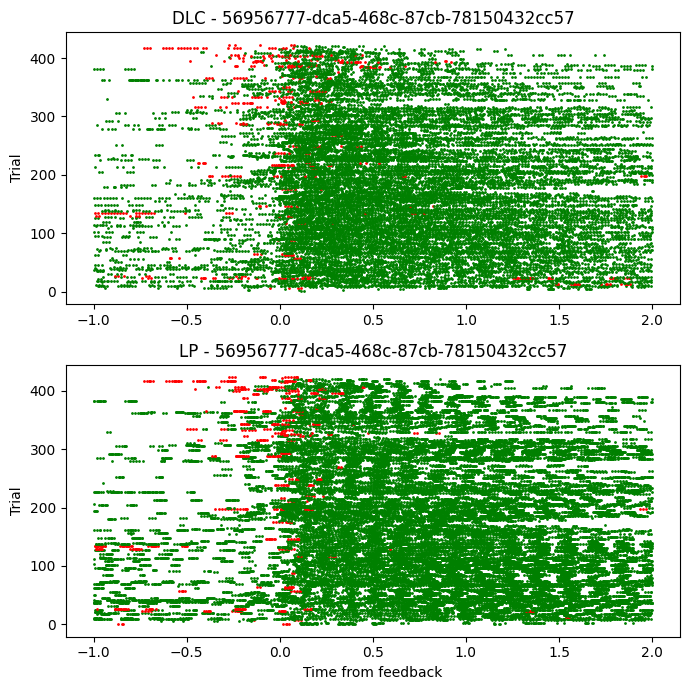

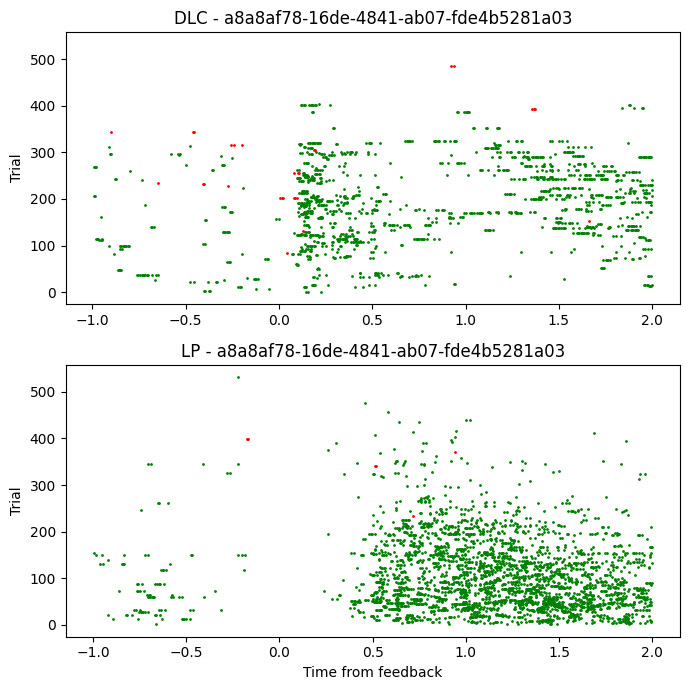

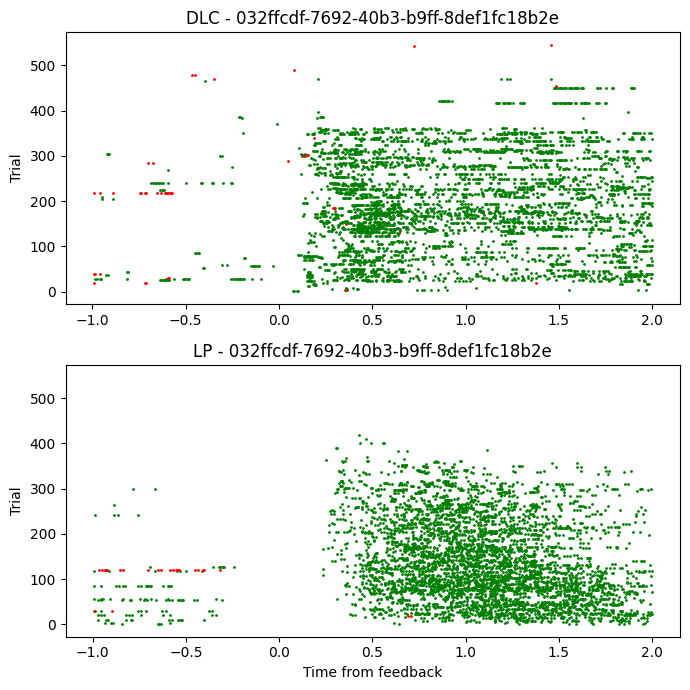

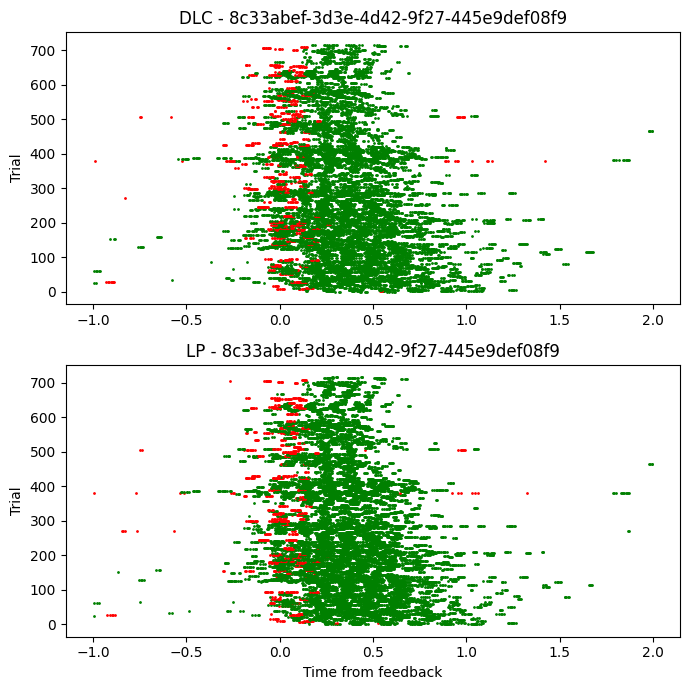

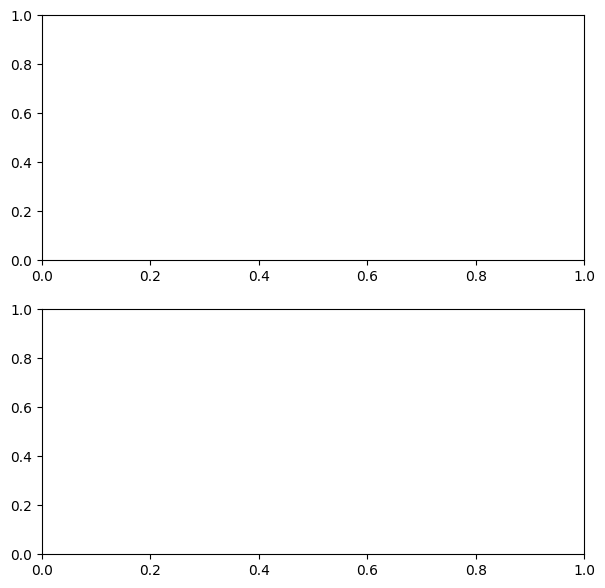

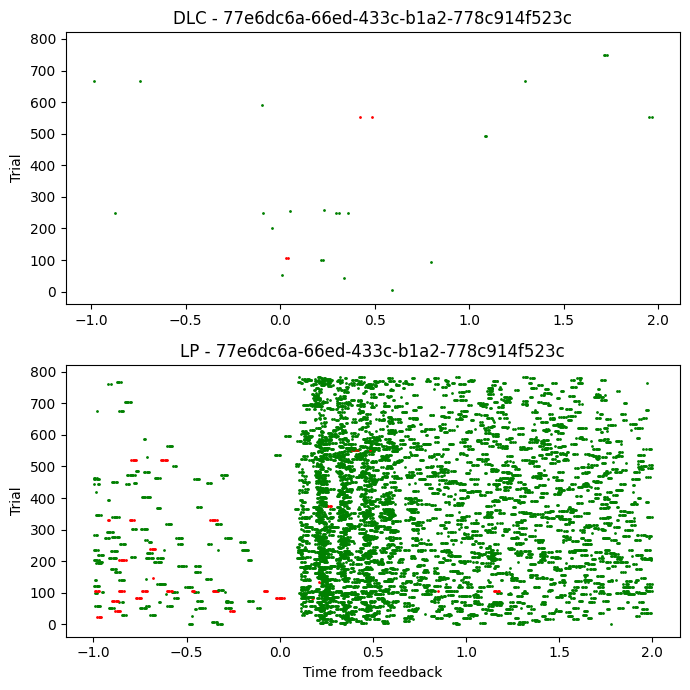

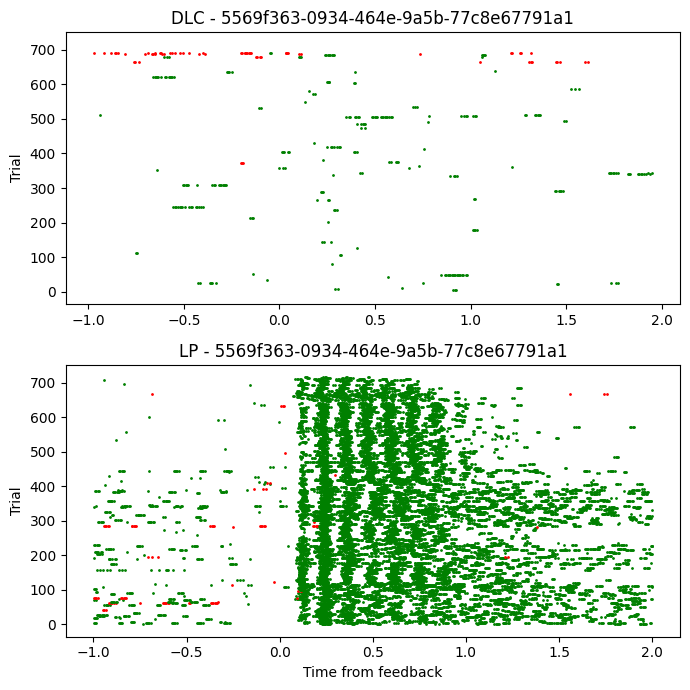

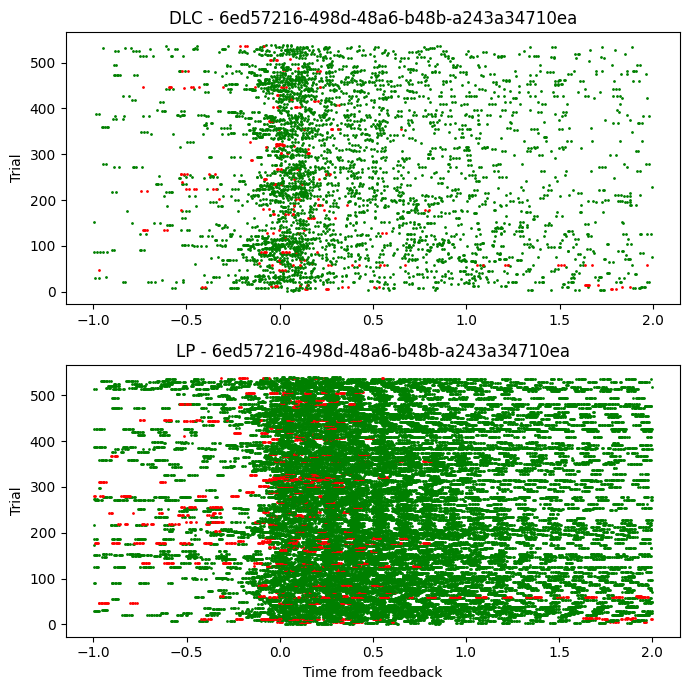

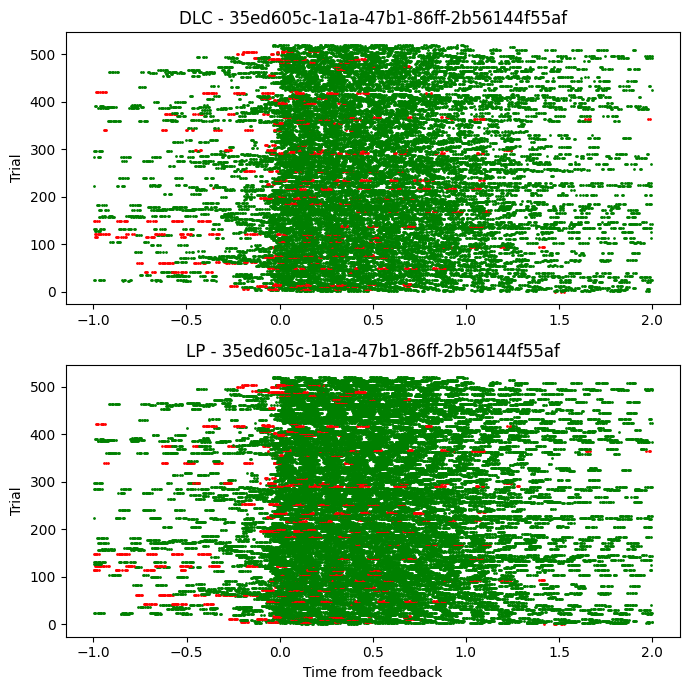

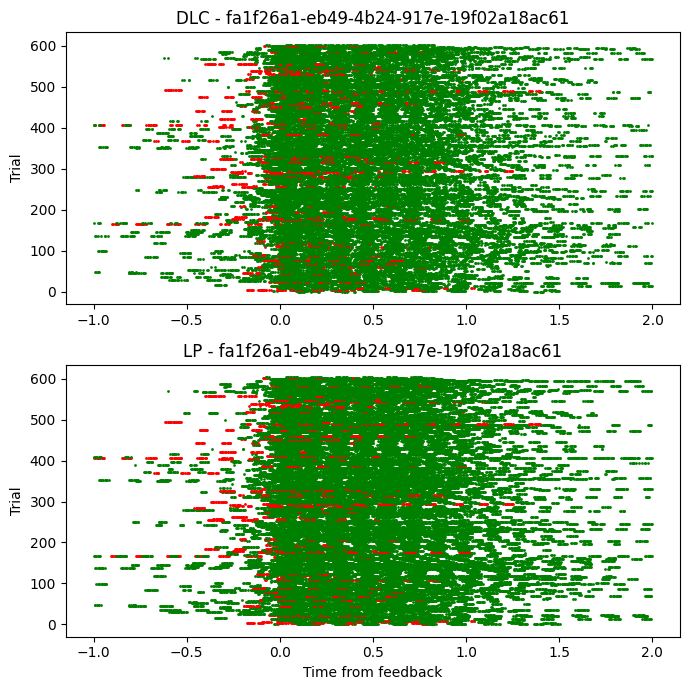

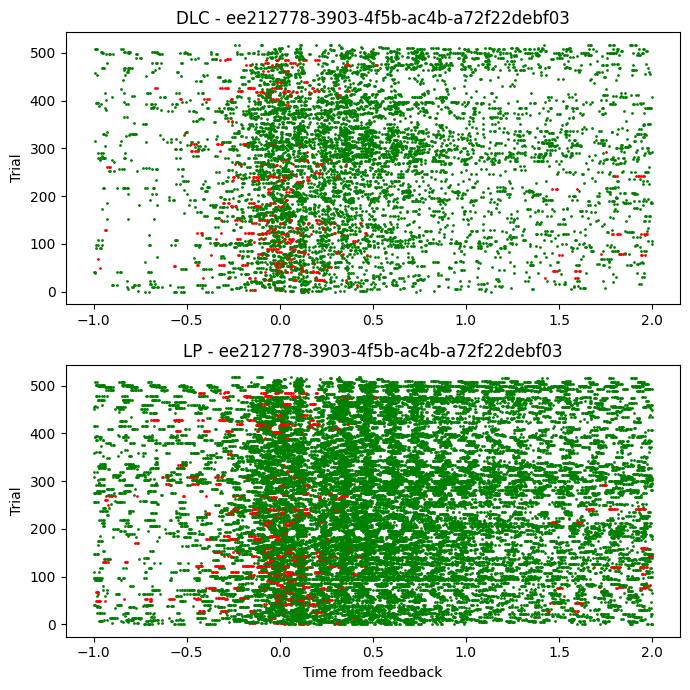

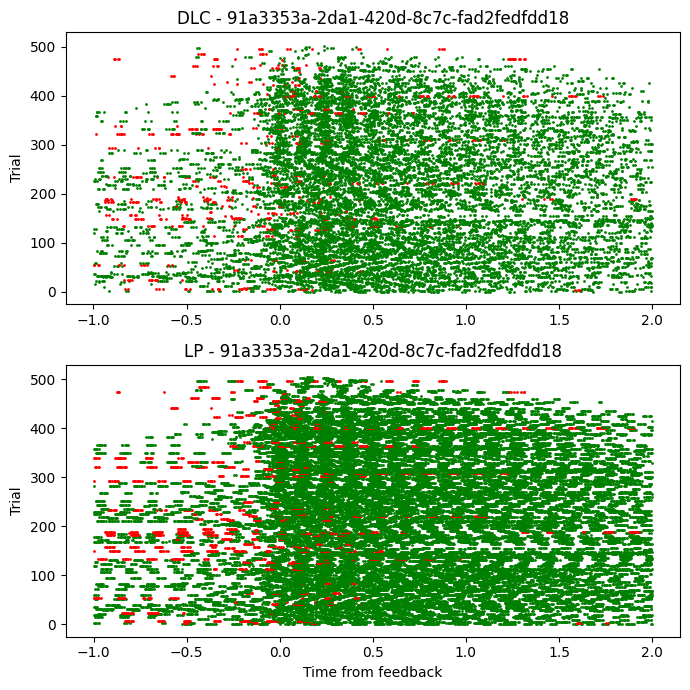

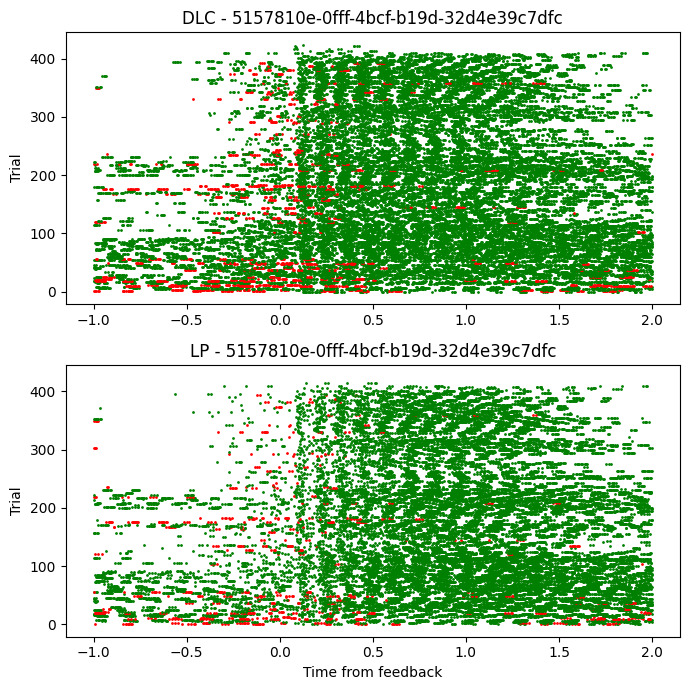

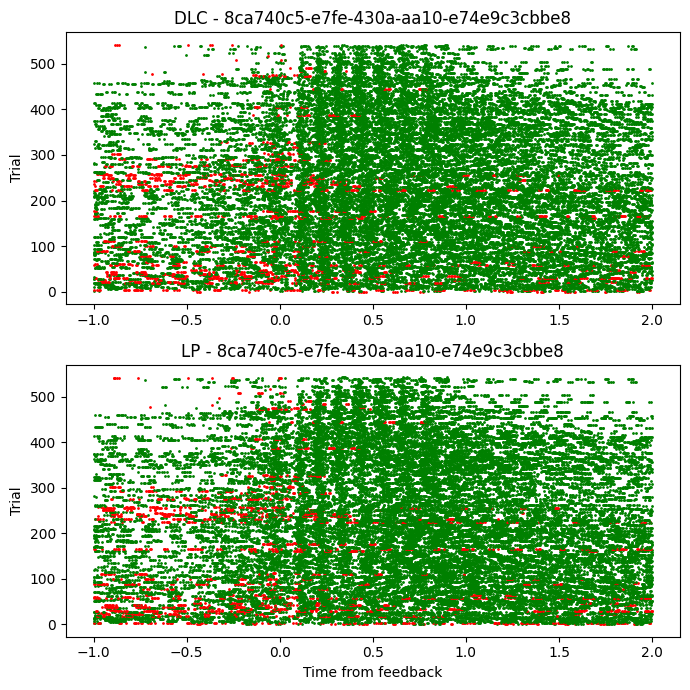

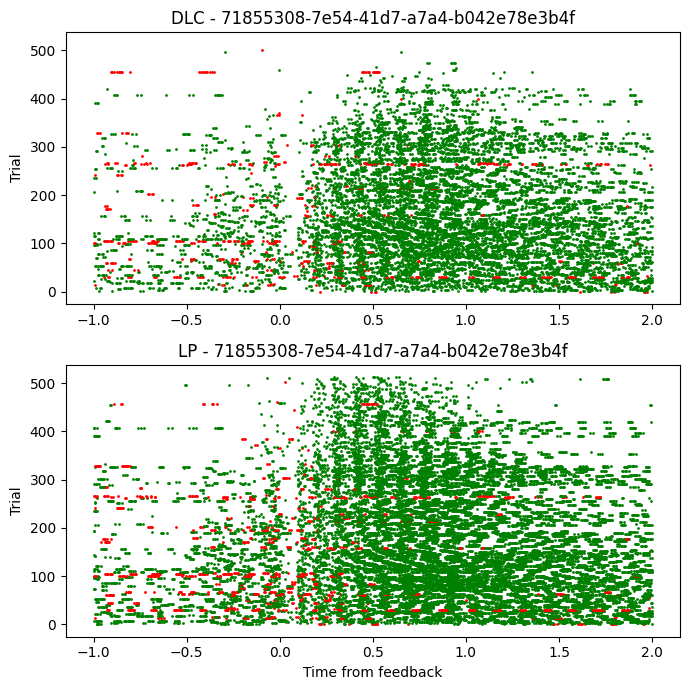

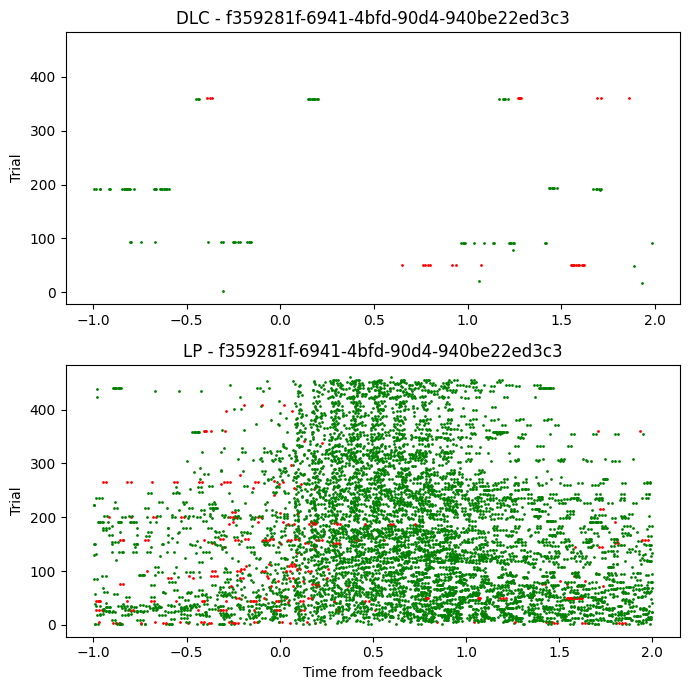

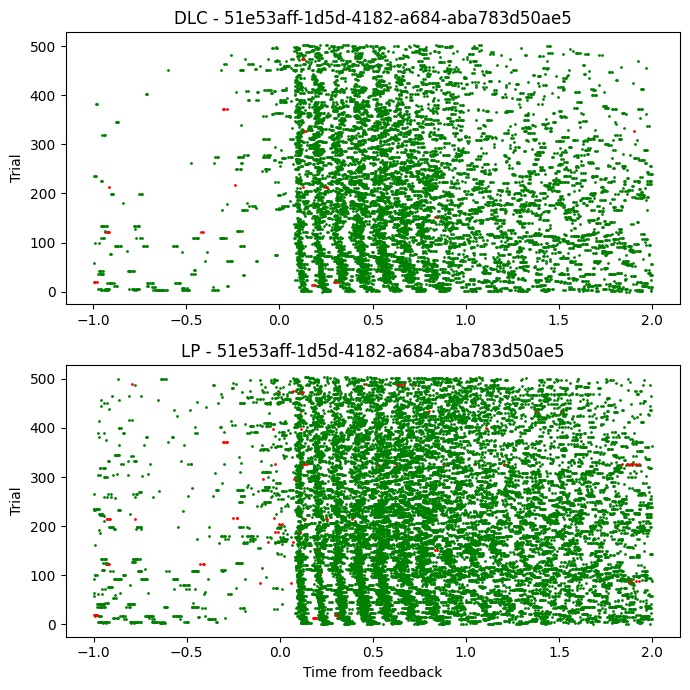

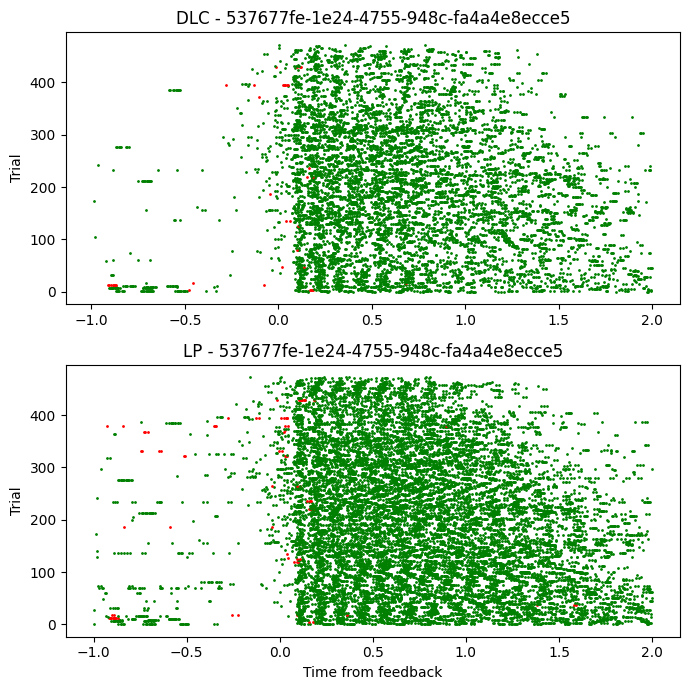

Error in callback <function flush_figures at 0x7fa73cd7cdc0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
save_path = prefix + '/representation_learning_variability/Video and wheel/Video QC/Figures/2_cameras/'
files = os.listdir(save_path)

eids = final_qc['eid'].unique()
for eid in eids:

    filename = str(save_path + eid + '_2_camera_lick_psth_-12_feedback.png')
    if filename not in files:

        fig, ax = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=True, figsize=[7, 7])
        trials = one.load_object(eid, obj='trials', namespace='ibl')
        trial_df = trials.to_df()

        try:
            lick_times_lp = get_lick_times(one, eid, lp=True, combine=True, video_type = 'left')
            data_lp = lick_psth(trial_df, lick_times_lp, 1, 2, event='feedback_times')

            lick_times_dlc = get_lick_times(one, eid, lp=False, combine=True, video_type = 'left')
            data_dlc = lick_psth(trial_df, lick_times_dlc, 1, 2, event='feedback_times')

            for d, data in enumerate([data_dlc, data_lp]):
                trials = data['trial']
                num_trials = int(np.max(trials))
                # Plot data
                for t, trial in enumerate(range(num_trials)):
                    licks_correct = np.array(data.loc[(data['trial']==t) & (data['correct']==1), 'lick_times'])
                    licks_incorrect = np.array(data.loc[(data['trial']==t) & (data['correct']==-1), 'lick_times'])
                    ax[d].scatter(licks_correct, np.full_like(licks_correct, t), color='green', s=1)
                    ax[d].scatter(licks_incorrect, np.full_like(licks_incorrect, t), color='red', s=1)
                ax[1].set_xlabel('Time from feedback')
                ax[d].set_ylabel('Trial')
                if d == 0:
                    ax[d].set_title('DLC - ' +eid)
                else:
                    ax[d].set_title('LP - ' +eid)
            plt.tight_layout()
            plt.savefig(filename, format='png')
            # plt.show()
        except:
            print('Missing data for mouse '+eid)
